# Part 1 Target Variable And Missing Feature Analysis
Written by John Xi Qiu

In [9]:
# import cell and define data paths
import pandas as pd
import missingno
import numpy as np
import math
import scipy
from scipy.stats import probplot
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from sklearn.preprocessing import normalize
from statsmodels.formula.api import ols
import statsmodels
import statsmodels.api as sm
from scripts import zillow_data_loader

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
########################################################
# To begin, verify these directory locations
data_dir = "~/kaggle/zillow/"
fig_write_dir = "figures/"
########################################################
merged = zillow_data_loader.load_train_data(data_dir)

Shape Of Loaded Merged Zillow Data:  (167888, 63)


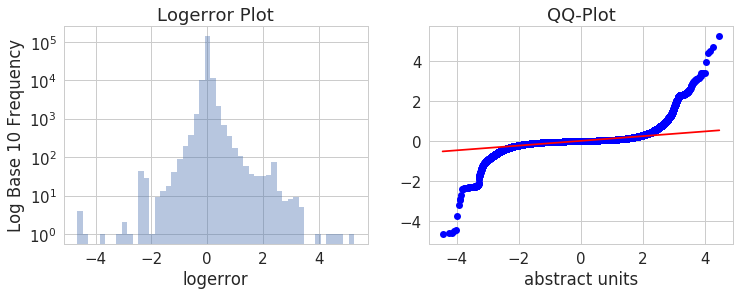

In [10]:
cat_var_list = zillow_data_loader.all_categorical_vars
#sns.set_style("whitegrid")
sns.set(font_scale=1.5)
#color = sns.color_palette()
sns.set_style("whitegrid", {'axes.grid' : True})
f, (ax_box, ax_hist) = plt.subplots(1,2,figsize=(12,4))
#sns.distplot(train_df.logerror.values, bins=50, kde=False)
sns_plot_1=probplot(merged['logerror'], plot= ax_hist)
sns_plot=sns.distplot(merged['logerror'], bins=None, kde=False,ax= ax_box)

ax_box.set_yscale("log")
ax_box.set(xlabel='logerror')
ax_box.set(ylabel = 'Log Base 10 Frequency')
ax_box.set(title = 'Logerror Plot')

ax_hist.set(xlabel='abstract units', title = "QQ-Plot")
ax_hist.yaxis.label.set_visible(False)
#plt.suptitle('Target Variable Distribution Analysis', fontsize=16)
plt.show()
out = sns_plot.get_figure()
out.savefig(fig_write_dir+'2-1.png', bbox_inches='tight',transparent = True, dpi=300)



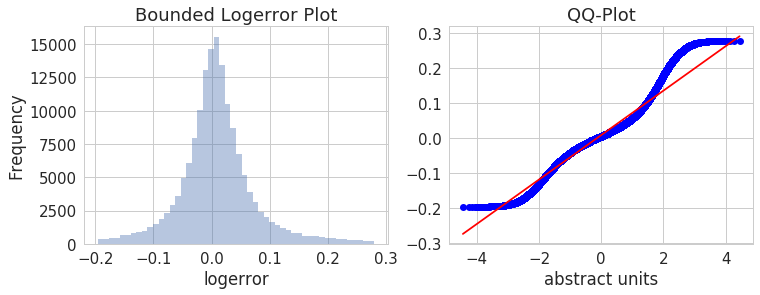

In [11]:
bound_df = zillow_data_loader.df_percentile_bound(merged,2.5,97.5)

#sns.set_style("whitegrid")
sns.set(font_scale=1.5)
#color = sns.color_palette()
sns.set_style("whitegrid", {'axes.grid' : True})
f, (ax_box, ax_hist) = plt.subplots(1,2,figsize=(12,4))
#sns.distplot(train_df.logerror.values, bins=50, kde=False)
sns_plot_1=probplot(bound_df['logerror'], plot= ax_hist)
sns_plot=sns.distplot(bound_df['logerror'],kde=False, ax=ax_box)

#ax_box.set_yscale("log")
ax_box.set(xlabel='logerror')
ax_box.set(ylabel = 'Frequency')
ax_box.set(title = 'Bounded Logerror Plot')

ax_hist.set(xlabel='abstract units', title = "QQ-Plot")
ax_hist.yaxis.label.set_visible(False)
#plt.suptitle('Target Variable Inner 95th Percentile Distributional analysis', fontsize=20)
plt.show()
out = sns_plot.get_figure()
out.savefig(fig_write_dir+'2-2.png', bbox_inches='tight',transparent = True, dpi=300)



In [12]:
print(bound_df.shape[0])

159477


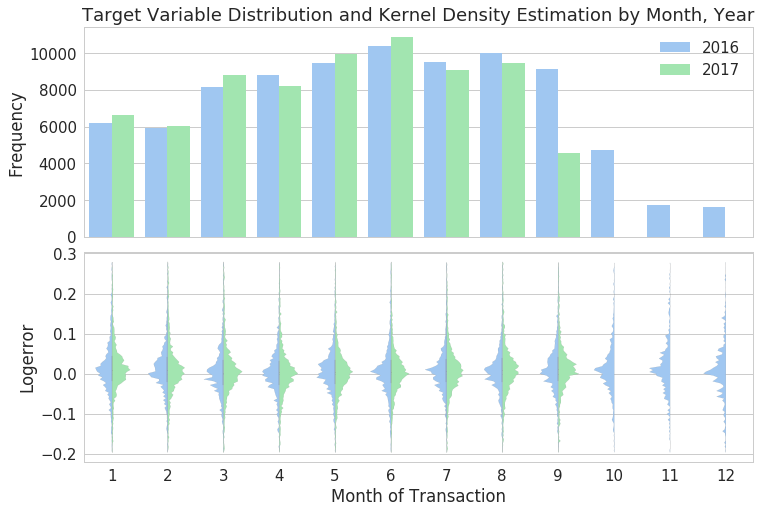

In [13]:
df = bound_df

sns.set_palette("pastel")
sns.set_style("whitegrid", {'axes.grid' : True})

f, (ax_top, ax_bot) = plt.subplots(2,figsize=(12,8), sharex=True)
f.subplots_adjust(hspace=0.07, wspace=0.025)

sns_plot = sns.countplot(x='transaction_month',hue='transaction_year',
              data = df,ax=ax_top)
sns_plot = sns.violinplot(x="transaction_month", y="logerror",
               hue='transaction_year',ax=ax_bot,linewidth=.1,
               scale_hue=False, bw=.005, split=True,data=df)
               #inner = 'quartile',data=df)
                #scale = "count", inner = 'quartile',data=df)
ax_top.xaxis.label.set_visible(False)

ax_top.legend(title="",loc='upper right')
ax_bot.legend_.remove()
ax_top.set(ylabel='Frequency')
ax_bot.set(ylabel = 'Logerror',xlabel='Month of Transaction')
ax_top.set_title('Target Variable Distribution and Kernel Density Estimation by Month, Year')
f.show()
out = sns_plot.get_figure()
out.savefig(fig_write_dir+'2-3.png', bbox_inches='tight',transparent = True, dpi=300)


                                              sum_sq        df          F  \
C(transaction_month)                        1.482121       8.0  43.544231   
C(transaction_year)                         0.114279       1.0  26.859749   
C(transaction_month):C(transaction_year)    0.063335       8.0   1.860751   
Residual                                  643.842218  151327.0        NaN   

                                                PR(>F)  
C(transaction_month)                      2.467270e-70  
C(transaction_year)                       2.190480e-07  
C(transaction_month):C(transaction_year)  6.140899e-02  
Residual                                           NaN  


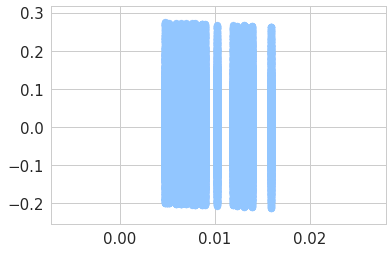

In [14]:
# anova without months 10-12
no_q4 = bound_df
no_q4['transaction_month'] =(no_q4['transaction_month'].astype(int))
no_q4 = no_q4[-no_q4['transaction_month'].isin([10,11,12])]
#no_q4 = bound_df[-bound_df['transaction_month'].isin([10,11,12])]
#no_q4 = bound_df[-bound_df['transaction_month'].isin([10,11,12])]

lm = ols('logerror ~ C(transaction_month)*C(transaction_year)',
         data=no_q4).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame

print(table)
#print(lm.summary())
resid = lm.resid
plt.scatter(lm.predict(), resid)

In [15]:
all_miss,train_miss = [],[]
properties17 = pd.read_csv(data_dir + 'properties_2017.csv')
# calculate missing data percent, show if variable is categorical
col_names = list(merged)
good_num_vars = []
good_cat_vars = []
all_good_vars = []
mostly_good_vars = []
all_miss = []
train_miss = []
miss_diff = []
miss_df = pd.DataFrame(columns=['feat', 'train_missing', 'test_missing'])
for ith,col in enumerate(sorted(col_names[3:])):
    if col not in ['transaction_month','transaction_year',"month_year"]:
        missing_perc = sum(pd.isnull(merged[col]))/merged.shape[0]
        missing_all = sum(pd.isnull(properties17[col]))/properties17.shape[0]
        #print(",".join(str(x) for x in [ith,col, col in cat_var_list,
        #                                (100*missing_perc),(100*missing_all)]))
        if not col in cat_var_list and missing_perc < .05 and col != 'assessmentyear':
            
            good_num_vars.append((col,missing_perc))
        if col in cat_var_list and missing_perc < .5:
            good_cat_vars.append((col,missing_perc))
        if missing_perc < .20:
            all_good_vars.append(col)
        if missing_perc < .20 and missing_perc>0.0:
            mostly_good_vars.append(col)    
        all_miss.append(missing_all)
        train_miss.append(missing_perc)
        if missing_all < 75:
            miss_diff.append((missing_all-missing_perc)*100)

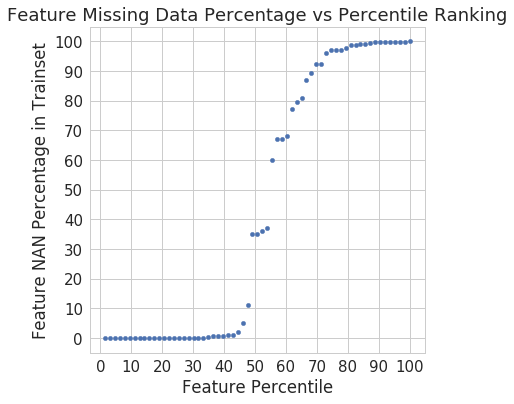

In [16]:
import matplotlib as mpl
import matplotlib.ticker as ticker
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')

f, ax = plt.subplots(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : True})
df = bound_df
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>=0]
missing_df = missing_df.sort_values(by='missing_count',ascending=True)
missing_df['missing_perc'] = (missing_df['missing_count']/merged.shape[0])*100
missing_percentile = []
num_feats = len(missing_df['missing_perc'])
missing_df['missing_perc_quartile']=(np.array(range(1,num_feats+1))/num_feats)*100
points = plt.scatter(missing_df["missing_perc_quartile"], missing_df["missing_perc"],
                     s=20, color="C0") #set style options
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title("Feature Missing Data Percentage vs Percentile Ranking")
out = sns_plot.get_figure()
ax.set(xlabel='Feature Percentile')
ax.set(ylabel = 'Feature NAN Percentage in Trainset')
plt.savefig(fig_write_dir+'2-5.png', bbox_inches='tight',transparent = True, dpi=300)

plt.show()


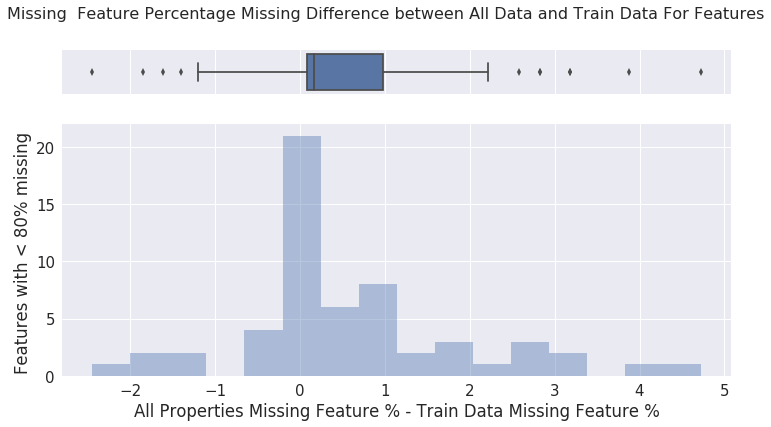

0.17033355741910006


In [17]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
color = sns.color_palette()
#\miss_diff = (np.array(all_miss)-np.array(train_miss))*100

f, (ax_box, ax_hist) = plt.subplots(2,figsize=(12,6), sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns_plot = sns.distplot(miss_diff,kde=False,ax=ax_hist)
sns_plot = sns.boxplot(miss_diff,ax=ax_box)

#plt.title('Training Data Log-Error (Labels) Availability by Month, Year')
ax_hist.set(xlabel='All Properties Missing Feature % - Train Data Missing Feature %')
ax_hist.set(ylabel = 'Features with < 80% missing ')
plt.suptitle('Missing  Feature Percentage Missing Difference between All Data and Train Data For Features', fontsize=16)
plt.show()

out = sns_plot.get_figure()
out.savefig(fig_write_dir+'2-4.png', bbox_inches='tight',transparent = True)
#print(miss_diff.shape)
print(np.median(miss_diff))


9


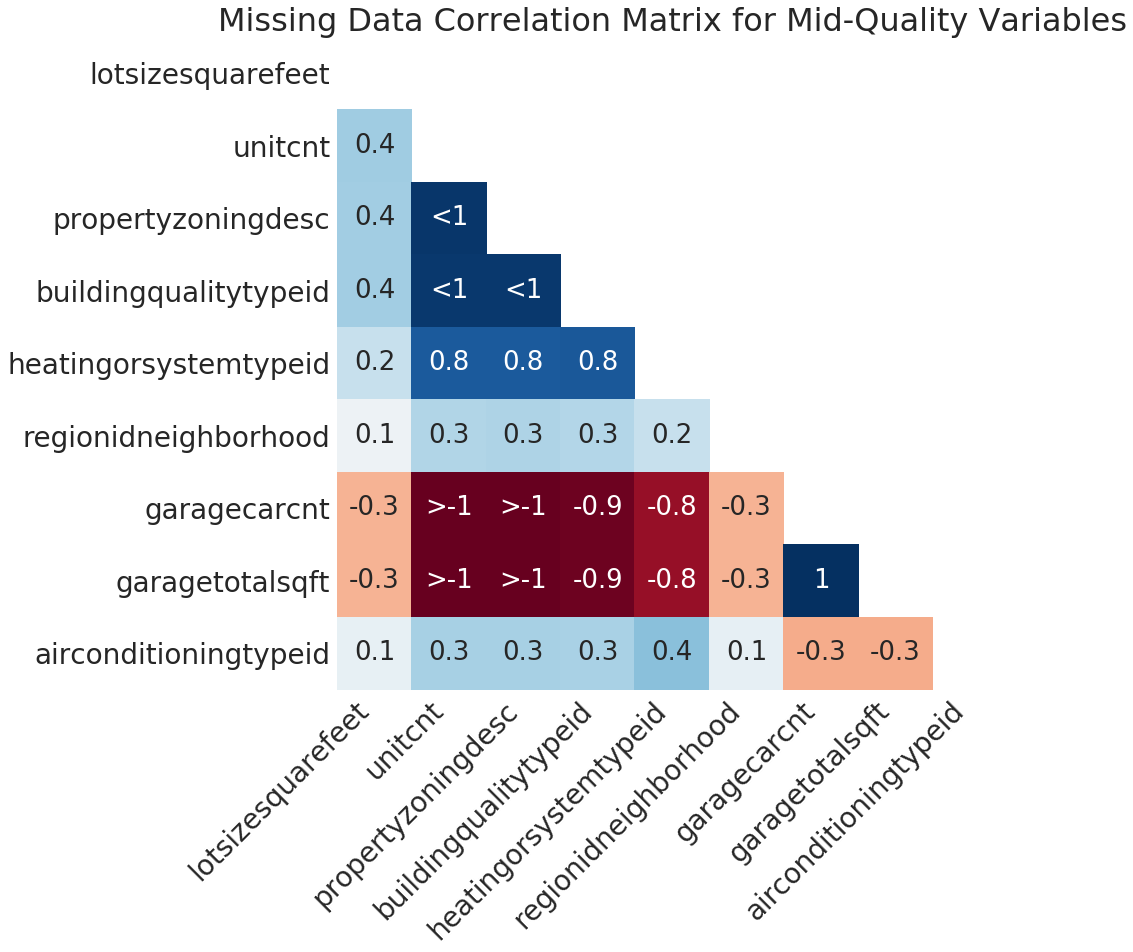

In [18]:
sns.set(font_scale=1.5)

mostly_df = missing_df.loc[(missing_df['missing_perc'] < 75) & (missing_df['missing_perc'] > 5)]
mostly_good_feats=mostly_df['column_name']
print(len(mostly_good_feats))
sns_plot = missingno.heatmap(merged[mostly_good_feats],figsize=(12,12),
                       cmap="RdBu",fontsize=28)
sns_plot.set_title("Missing Data Correlation Matrix for Mid-Quality Variables", fontsize=32)
out = sns_plot.get_figure()
out.savefig(fig_write_dir+'2-6.png', bbox_inches='tight',transparent = True, dpi=300)


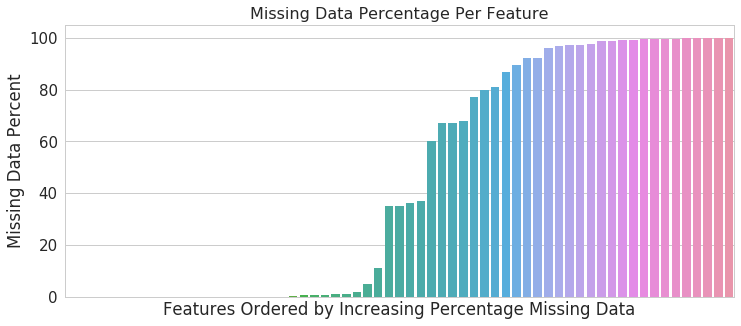

In [19]:
df = bound_df
sns.set_palette("Blues")
sns.set_style("whitegrid", {'axes.grid' : True})
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>=0]
missing_df = missing_df.sort_values(by='missing_count',ascending=True)
missing_df['missing_perc'] = (missing_df['missing_count']/merged.shape[0])*100
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,5))
rects = ax = sns.barplot(x="column_name", y="missing_perc", data=missing_df)
ax.tick_params(labelbottom='off') 
ax.set_xlabel("Percent of Feature's Values Missing in Trainset Lots ")
ax.set_title("Missing Data Percentage Per Feature", fontsize=16)

ax.set(xlabel='Features Ordered by Increasing Percentage Missing Data')
ax.set(ylabel = 'Missing Data Percent')

plt.show()
out = sns_plot.get_figure()
#fig.savefig(fig_write_dir+'2-6.png', bbox_inches='tight',transparent = True, dpi=300)


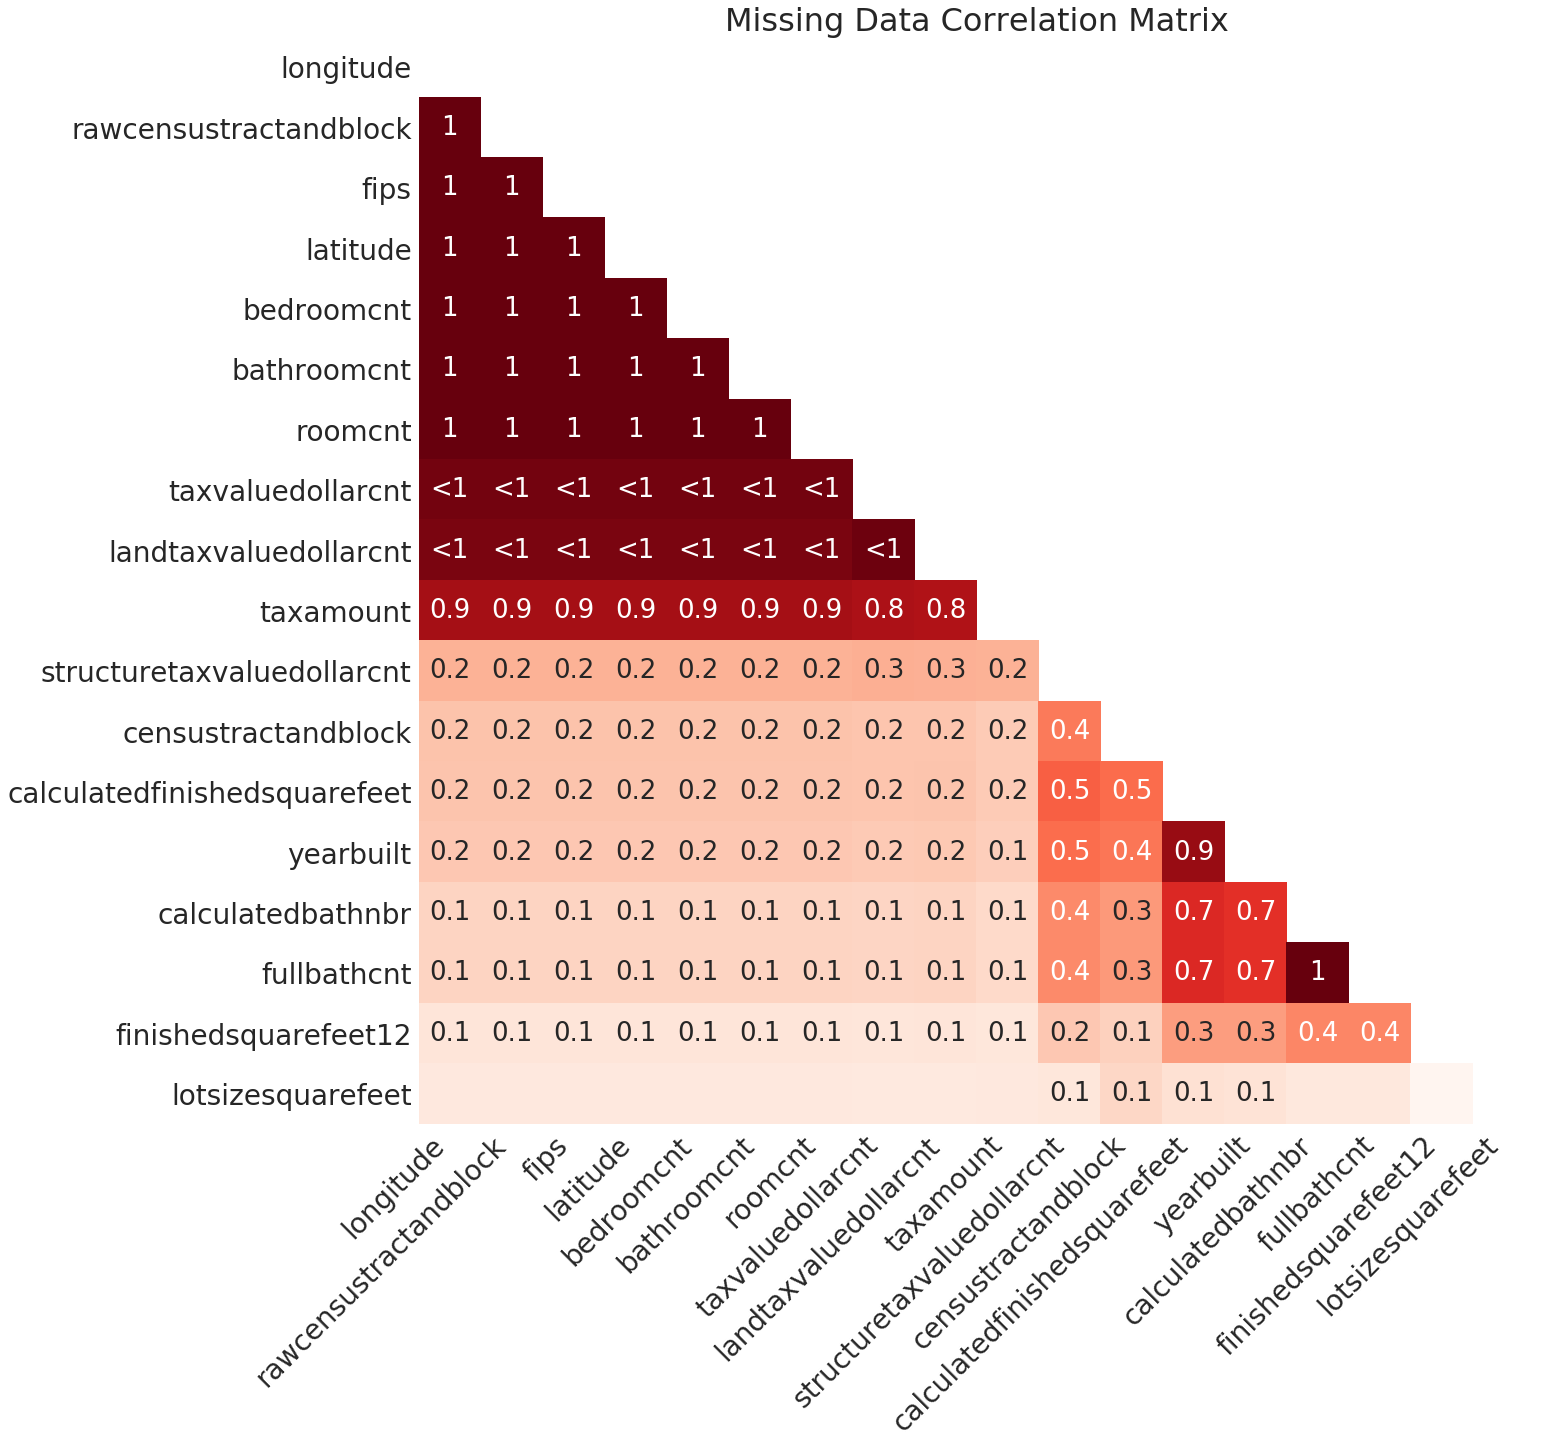

In [20]:
good_feats_df = missing_df.loc[missing_df.column_name.isin(zillow_data_loader.good_feats)]
mostly_good_feats = good_feats_df.column_name.loc[missing_df.missing_perc < 20 ]

sns_plot = missingno.heatmap(merged[mostly_good_feats],figsize=(20,20),
                       cmap="Reds",fontsize=28)
sns_plot.set_title("Missing Data Correlation Matrix", fontsize=32)
out = sns_plot.get_figure()
#out.savefig(fig_write_dir+'2-6.png', bbox_inches='tight',transparent = True, dpi=300)
